Data visualization requirement (do for all used dataset):
1. ~~Analyse how each class looks like in CNN. Show the common difference for each class.~~
1. ~~Show whether the dataset is balanced, how is it’s distribution~~
1. ~~Random samples a batch of images from dataset~~
1. ~~Show 3 or 6 images on how each classes look like (can refer reference 3)~~
1. ~~Find mean image (check reference 2 for 4,5,6,7)~~
1. ~~Find contrast between average image (mean image)~~
1. ~~The variation between image~~
1. ~~Eigenimage~~
1. ~~PCA/t-SNE visualization on predicted results, determines separability of model.~~

TO BE ADDED.. (pls add too if u have any good idea)

In [1]:
import pandas as pd
import numpy as np
import math
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

In [48]:
torch.manual_seed(0)
np.random.seed(0)

In [49]:
data_dir = 'rafdb/aligned/'
data = [t.rstrip().split() for t in open('list_patition_label.txt', 'r').readlines()]
data = np.array([[t[0][:-4]+'_aligned'+t[0][-4:], t[1]] for t in labels])
idx = np.random.permutation(len(data))
data = data[idx]

In [182]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        # convert to single channel
        # https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil
        return img.convert('L')

In [183]:
df = pd.DataFrame()
df['image'] = data[:, 0]
df['emotion'] = [int(i) for i in data[:, 1]]
df['pixels'] = [np.array(pil_loader(data_dir+img)) for img in df['image']]
df['Usage'] = 'train'
df['Usage'][12000:] = 'valid'
df = df[['Usage', 'emotion', 'pixels']]
df

<ipython-input-183-d0272fc10b1b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Usage'][12000:] = 'valid'


Usage  emotion                                             pixels
0      train        7  [[131, 93, 82, 94, 84, 67, 77, 98, 74, 70, 64,...
1      train        1  [[42, 81, 90, 83, 86, 126, 91, 69, 83, 62, 63,...
2      train        3  [[71, 70, 50, 68, 78, 66, 71, 53, 62, 74, 89, ...
3      train        6  [[135, 115, 106, 127, 145, 136, 139, 165, 182,...
4      train        5  [[155, 159, 164, 167, 168, 169, 170, 171, 175,...
...      ...      ...                                                ...
15334  valid        6  [[38, 39, 37, 50, 68, 64, 49, 46, 63, 57, 39, ...
15335  valid        4  [[68, 65, 63, 63, 64, 66, 66, 66, 67, 66, 65, ...
15336  valid        7  [[38, 30, 23, 26, 42, 68, 94, 109, 125, 129, 1...
15337  valid        7  [[74, 77, 80, 82, 81, 81, 82, 83, 86, 84, 83, ...
15338  valid        1  [[183, 181, 179, 179, 182, 188, 193, 197, 192,...

[15339 rows x 3 columns]

In [184]:
emotion_dic = {
    1: 'Surprise',
    2: 'Fear',
    3: 'Disgust',
    4: 'Happiness',
    5: 'Sadness',
    6: 'Anger',
    7: 'Neutral'
}

In [185]:
usage = pd.DataFrame(data=df['Usage'].value_counts()).rename(columns={'Usage': 'counts'}).sort_values(by='counts', ascending=False)
usage

counts
train   12000
valid    3339

In [186]:
emotion = pd.DataFrame(data=df['emotion'].value_counts()).rename(columns={'emotion': 'total'})
emotion['emotion'] = [emotion_dic.get(i) for i in emotion.index]
emotion['train'] = df[df['Usage']=='train']['emotion'].value_counts()
emotion['test'] = df[df['Usage']=='valid']['emotion'].value_counts()
emotion = emotion[['emotion', 'train', 'test', 'total']].sort_index()
display(emotion)

emotion  train  test  total
1   Surprise   1298   321   1619
2       Fear    285    70    355
3    Disgust    701   176    877
4  Happiness   4607  1350   5957
5    Sadness   1913   547   2460
6      Anger    697   170    867
7    Neutral   2499   705   3204

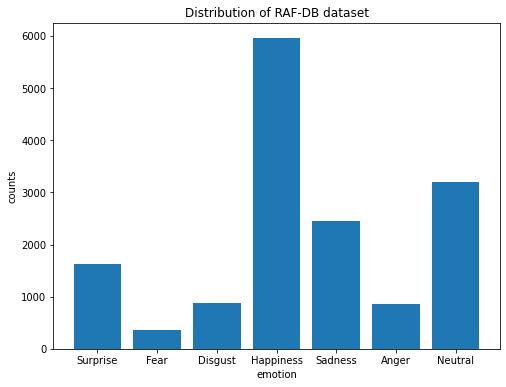

In [187]:
plt.figure(figsize=(8, 6))
plt.bar(data=emotion, x='emotion', height='total')
plt.title('Distribution of RAF-DB dataset')
plt.xlabel('emotion')
plt.ylabel('counts')
plt.show()

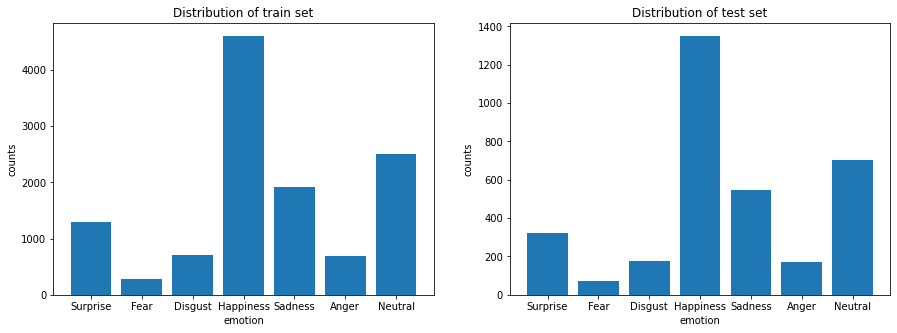

In [188]:
cols = list(emotion.columns[1:-1])
fig, axs = plt.subplots(1, len(cols), figsize=(15, 5))
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].bar(data=emotion, x='emotion', height=cols[i])
    axs[i].set_title(f'Distribution of {cols[i]} set')
    axs[i].set_ylabel('counts')
    axs[i].set_xlabel('emotion')

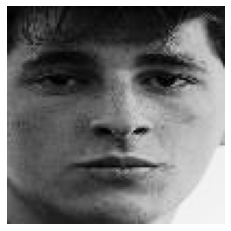

In [191]:
def show_pic(idx=np.random.choice(df.shape[0])):
    plt.imshow(df['pixels'][idx], cmap='Greys_r', vmin=0, vmax=255)
    plt.xlabel(emotion_dic.get(df['emotion'][idx+1]))
    plt.axis('off')
    plt.show()
show_pic()

In [192]:
img_arr = df['pixels']

In [193]:
img_arr.shape

(15339,)

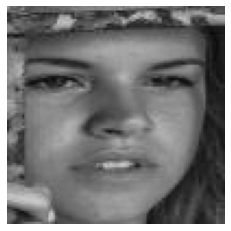

In [195]:
plt.imshow(img_arr[0], cmap='Greys_r', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [196]:
img_label = np.array(df['emotion'])

In [197]:
emotion_dic.get(img_label[0])

'Neutral'

In [198]:
n_classes = df['emotion'].nunique()

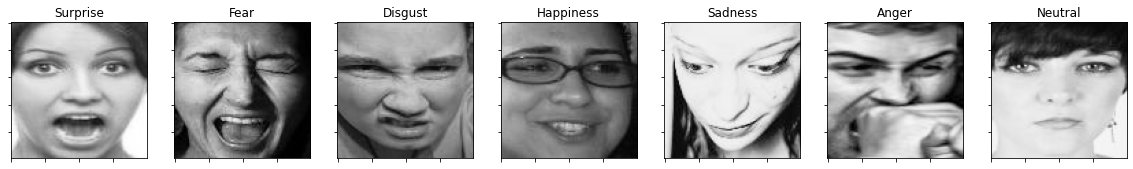

In [200]:
fig, axs = plt.subplots(1, n_classes, figsize=(20, 15))
axs = axs.ravel()
for i in range(len(axs)):
    idx = df[df['emotion']==i+1].sample().index[0]
    axs[i].imshow(img_arr[idx], cmap='Greys_r', vmin=0, vmax=255)
    axs[i].set_title(emotion_dic.get(img_label[idx]))
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

In [202]:
def plot_samples(label):
    fig, axs = plt.subplots(1, 5, figsize=(20, 15))
    axs = axs.ravel()
    for i in range(len(axs)):
        idx = df[df['emotion']==label+1].sample().index[0]
        axs[i].imshow(img_arr[idx], cmap='Greys_r', vmin=0, vmax=255)
        axs[i].set_title(emotion_dic.get(img_label[idx]))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

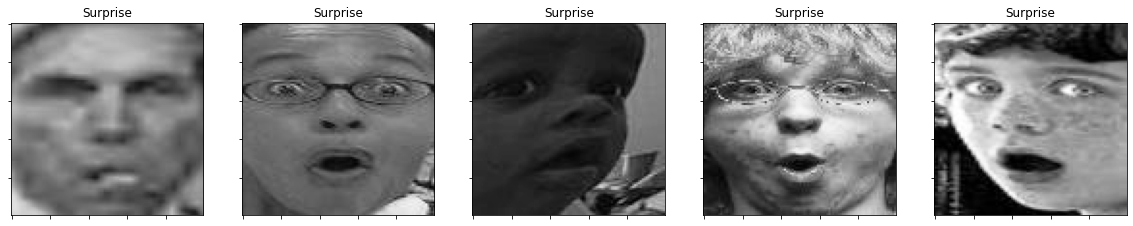

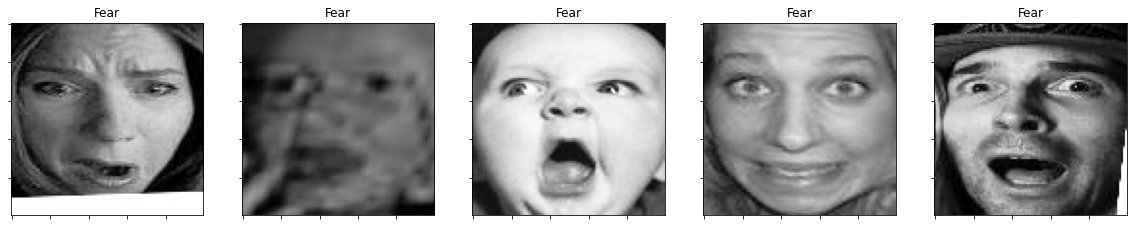

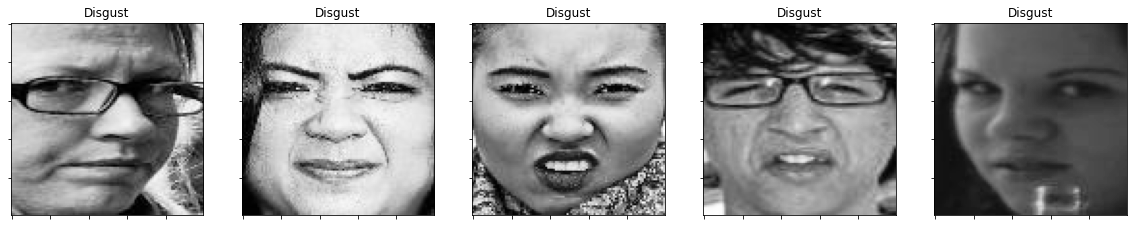

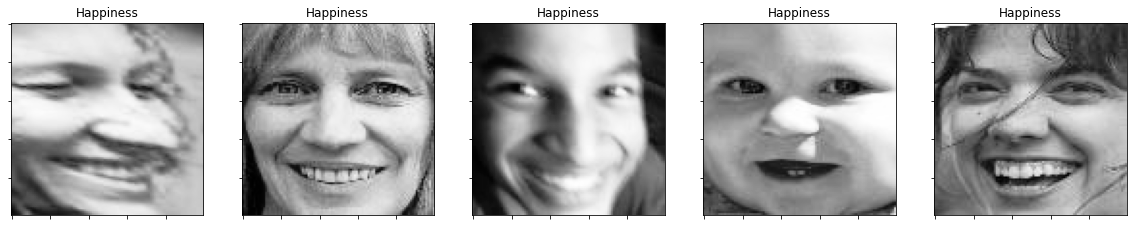

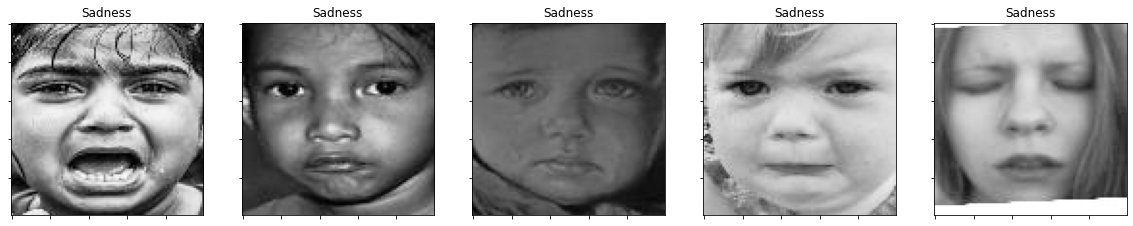

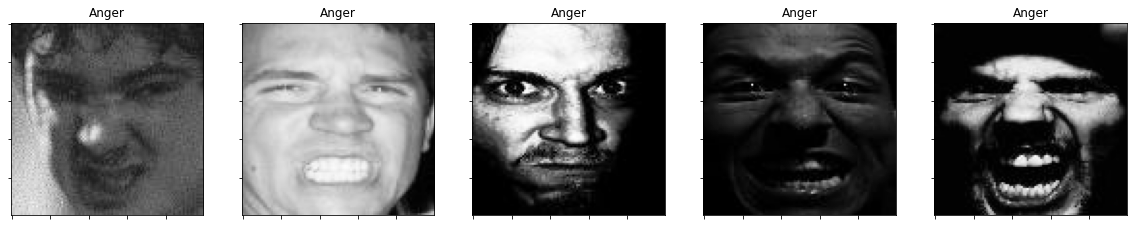

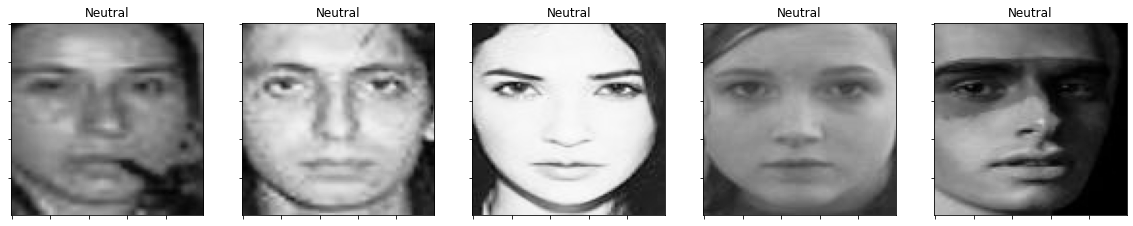

In [203]:
for i in range(n_classes):
    plot_samples(i)

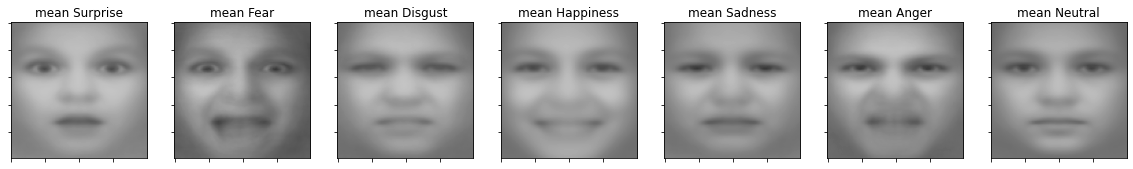

In [215]:
fig, axs = plt.subplots(1, n_classes, figsize=(20, 15))
axs = axs.ravel()
for i in range(len(axs)):
    mean_arr = [img for img in img_arr[img_label==i+1]]
    mean_img = np.mean(mean_arr, axis=0)
    axs[i].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axs[i].set_title(f'mean {emotion_dic.get(i+1)}')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

In [220]:
def plot_contrast(j):    
    mean_arr1 = [img for img in img_arr[img_label==j+1]]
    mean_img1 = np.mean(mean_arr1, axis=0)
    fig, axs = plt.subplots(1, n_classes, figsize=(20, 15))
    axs = axs.ravel()
    for i in range(len(axs)):
        mean_arr2 = [img for img in img_arr[img_label==i+1]]
        mean_img2 = np.mean(mean_arr2, axis=0)
        mean_contrast = mean_img1 - mean_img2
        axs[i].imshow(mean_contrast, cmap='bwr')
        axs[i].set_title(f'{emotion_dic.get(j+1)} - {emotion_dic.get(i+1)}')
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

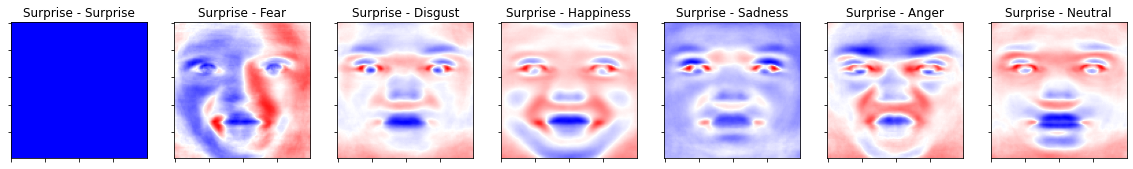

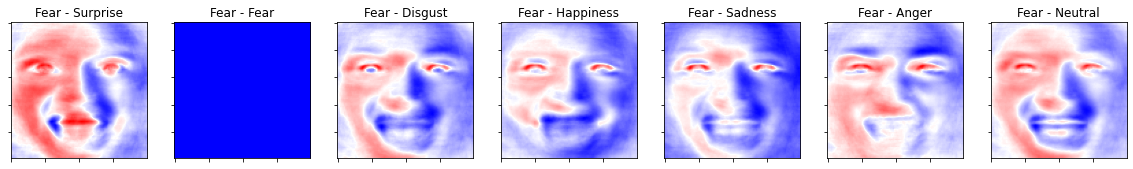

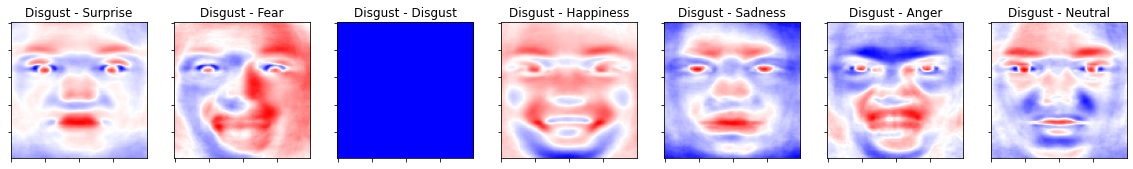

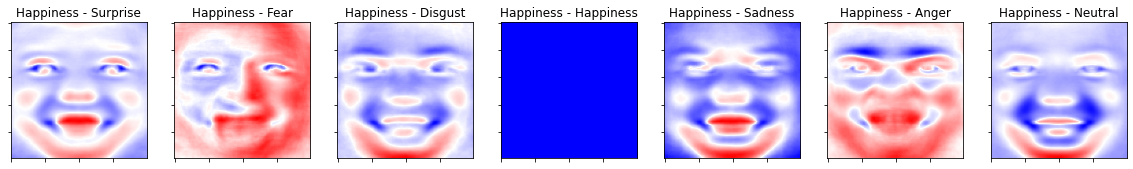

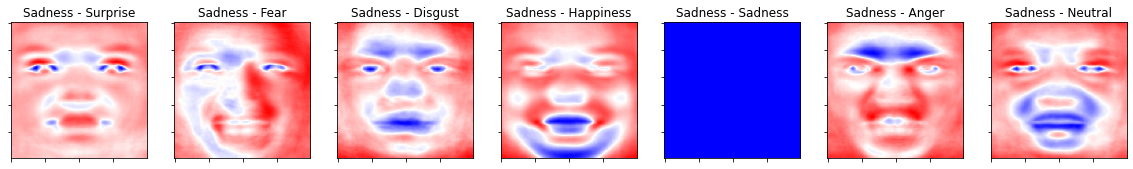

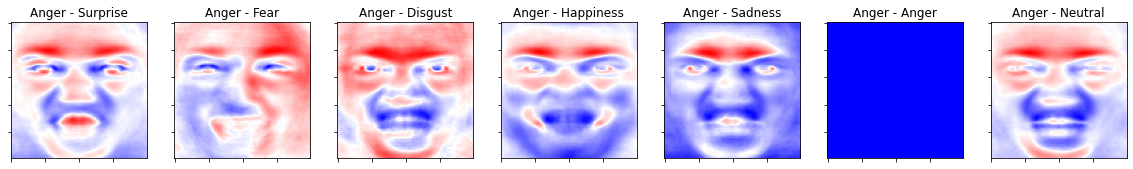

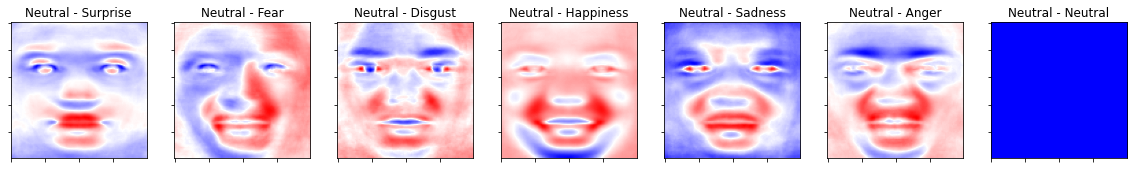

In [221]:
for i in range(n_classes):
    plot_contrast(i)

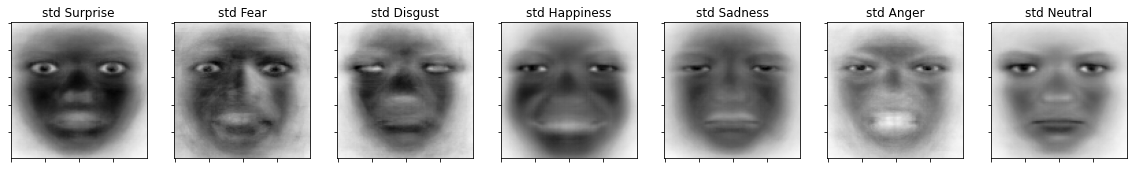

In [223]:
fig, axs = plt.subplots(1, n_classes, figsize=(20, 15))
axs = axs.ravel()
for i in range(len(axs)):
    std_arr = [img for img in img_arr[img_label==i+1]]
    std_img = np.std(std_arr, axis=0)
    axs[i].imshow(std_img, cmap='Greys_r')
    axs[i].set_title(f'std {emotion_dic.get(i+1)}')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

In [235]:
def plot_pca(idx):
    mat = [i.ravel() for i in img_arr[img_label==idx+1]]
    print(f'PCA of {emotion_dic.get(idx+1)}')
    pca = PCA(n_components=0.7, whiten=True)
    pca.fit(mat)
    print(f'Number of PC: {pca.n_components_}')
    n = pca.n_components_
    fig = plt.figure(figsize=(10,10))
    r = int(n**0.5)
    c = math.ceil(n / r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i+1, xticks=[], yticks=[])
        ax.imshow(pca.components_[i].reshape(100, 100), cmap='Greys_r')
    plt.axis('off')
    plt.show()

PCA of Surprise
Number of PC: 9


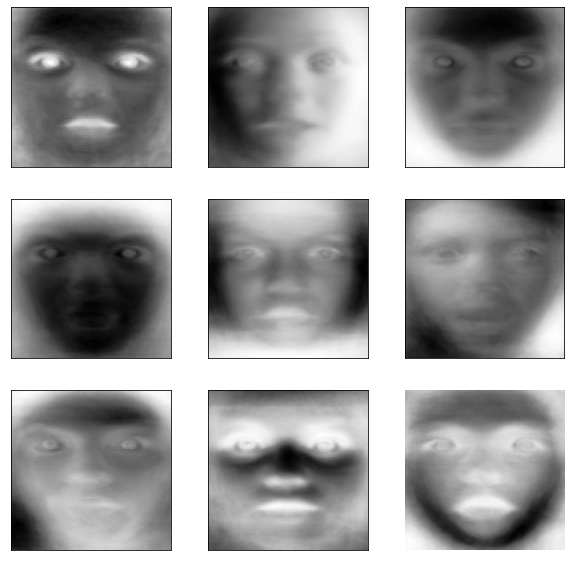

PCA of Fear
Number of PC: 11


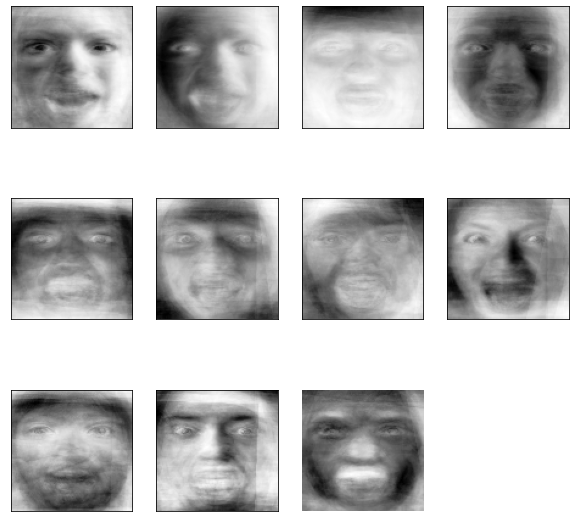

PCA of Disgust
Number of PC: 9


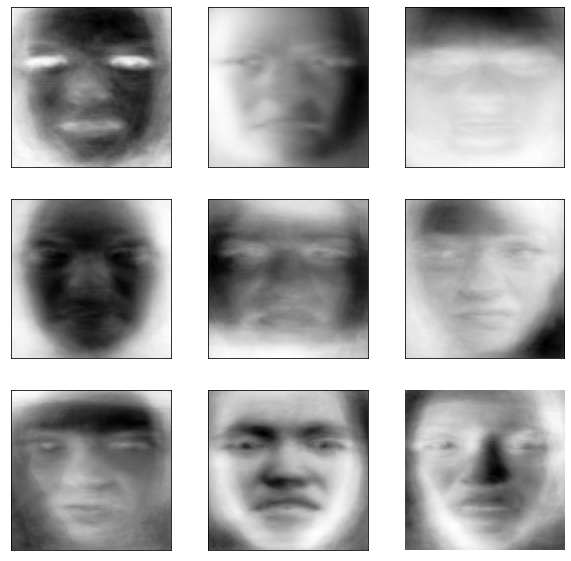

PCA of Happiness
Number of PC: 8


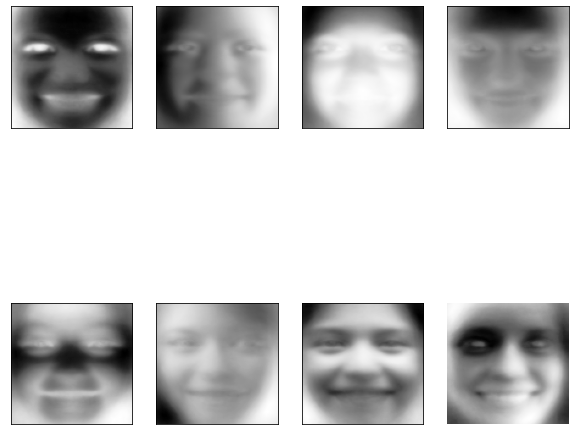

PCA of Sadness
Number of PC: 10


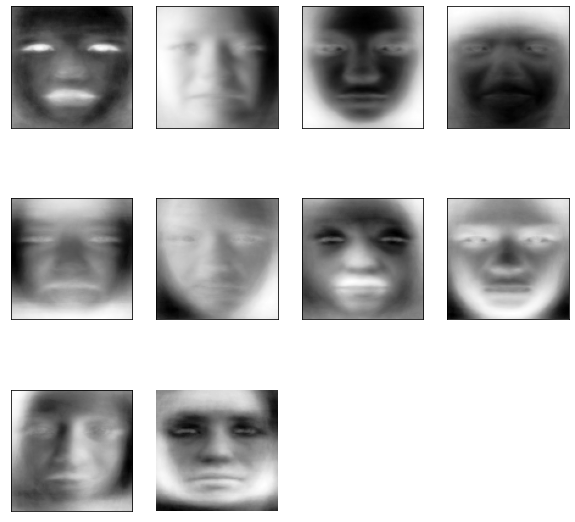

PCA of Anger
Number of PC: 12


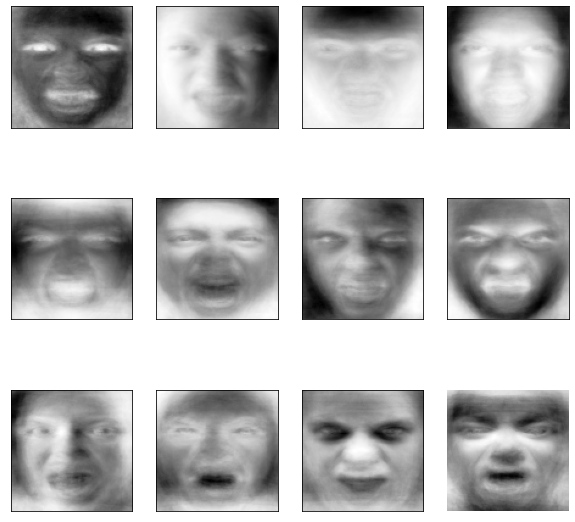

PCA of Neutral
Number of PC: 8


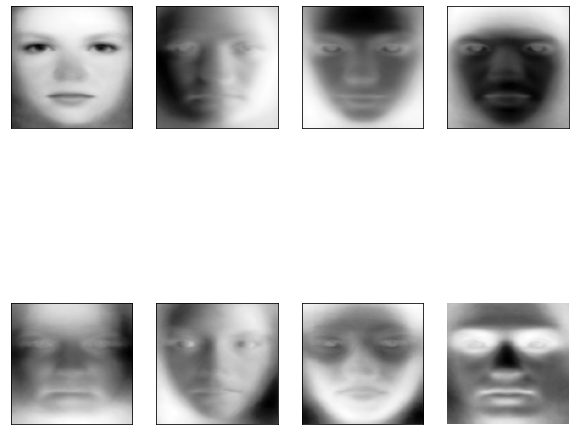

In [236]:
for i in range(n_classes):
    plot_pca(i)

In [237]:
def plot_embedding(X):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(30, 30))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(img_label[i]),
                 color=plt.cm.Set1(img_label[i] / n_classes),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img_arr[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE embedding of RAF-DB')

In [238]:
tsne = TSNE(n_components=2, init='pca', random_state=428)
mat = [i.ravel() for i in img_arr]
X_tsne = tsne.fit_transform(mat)

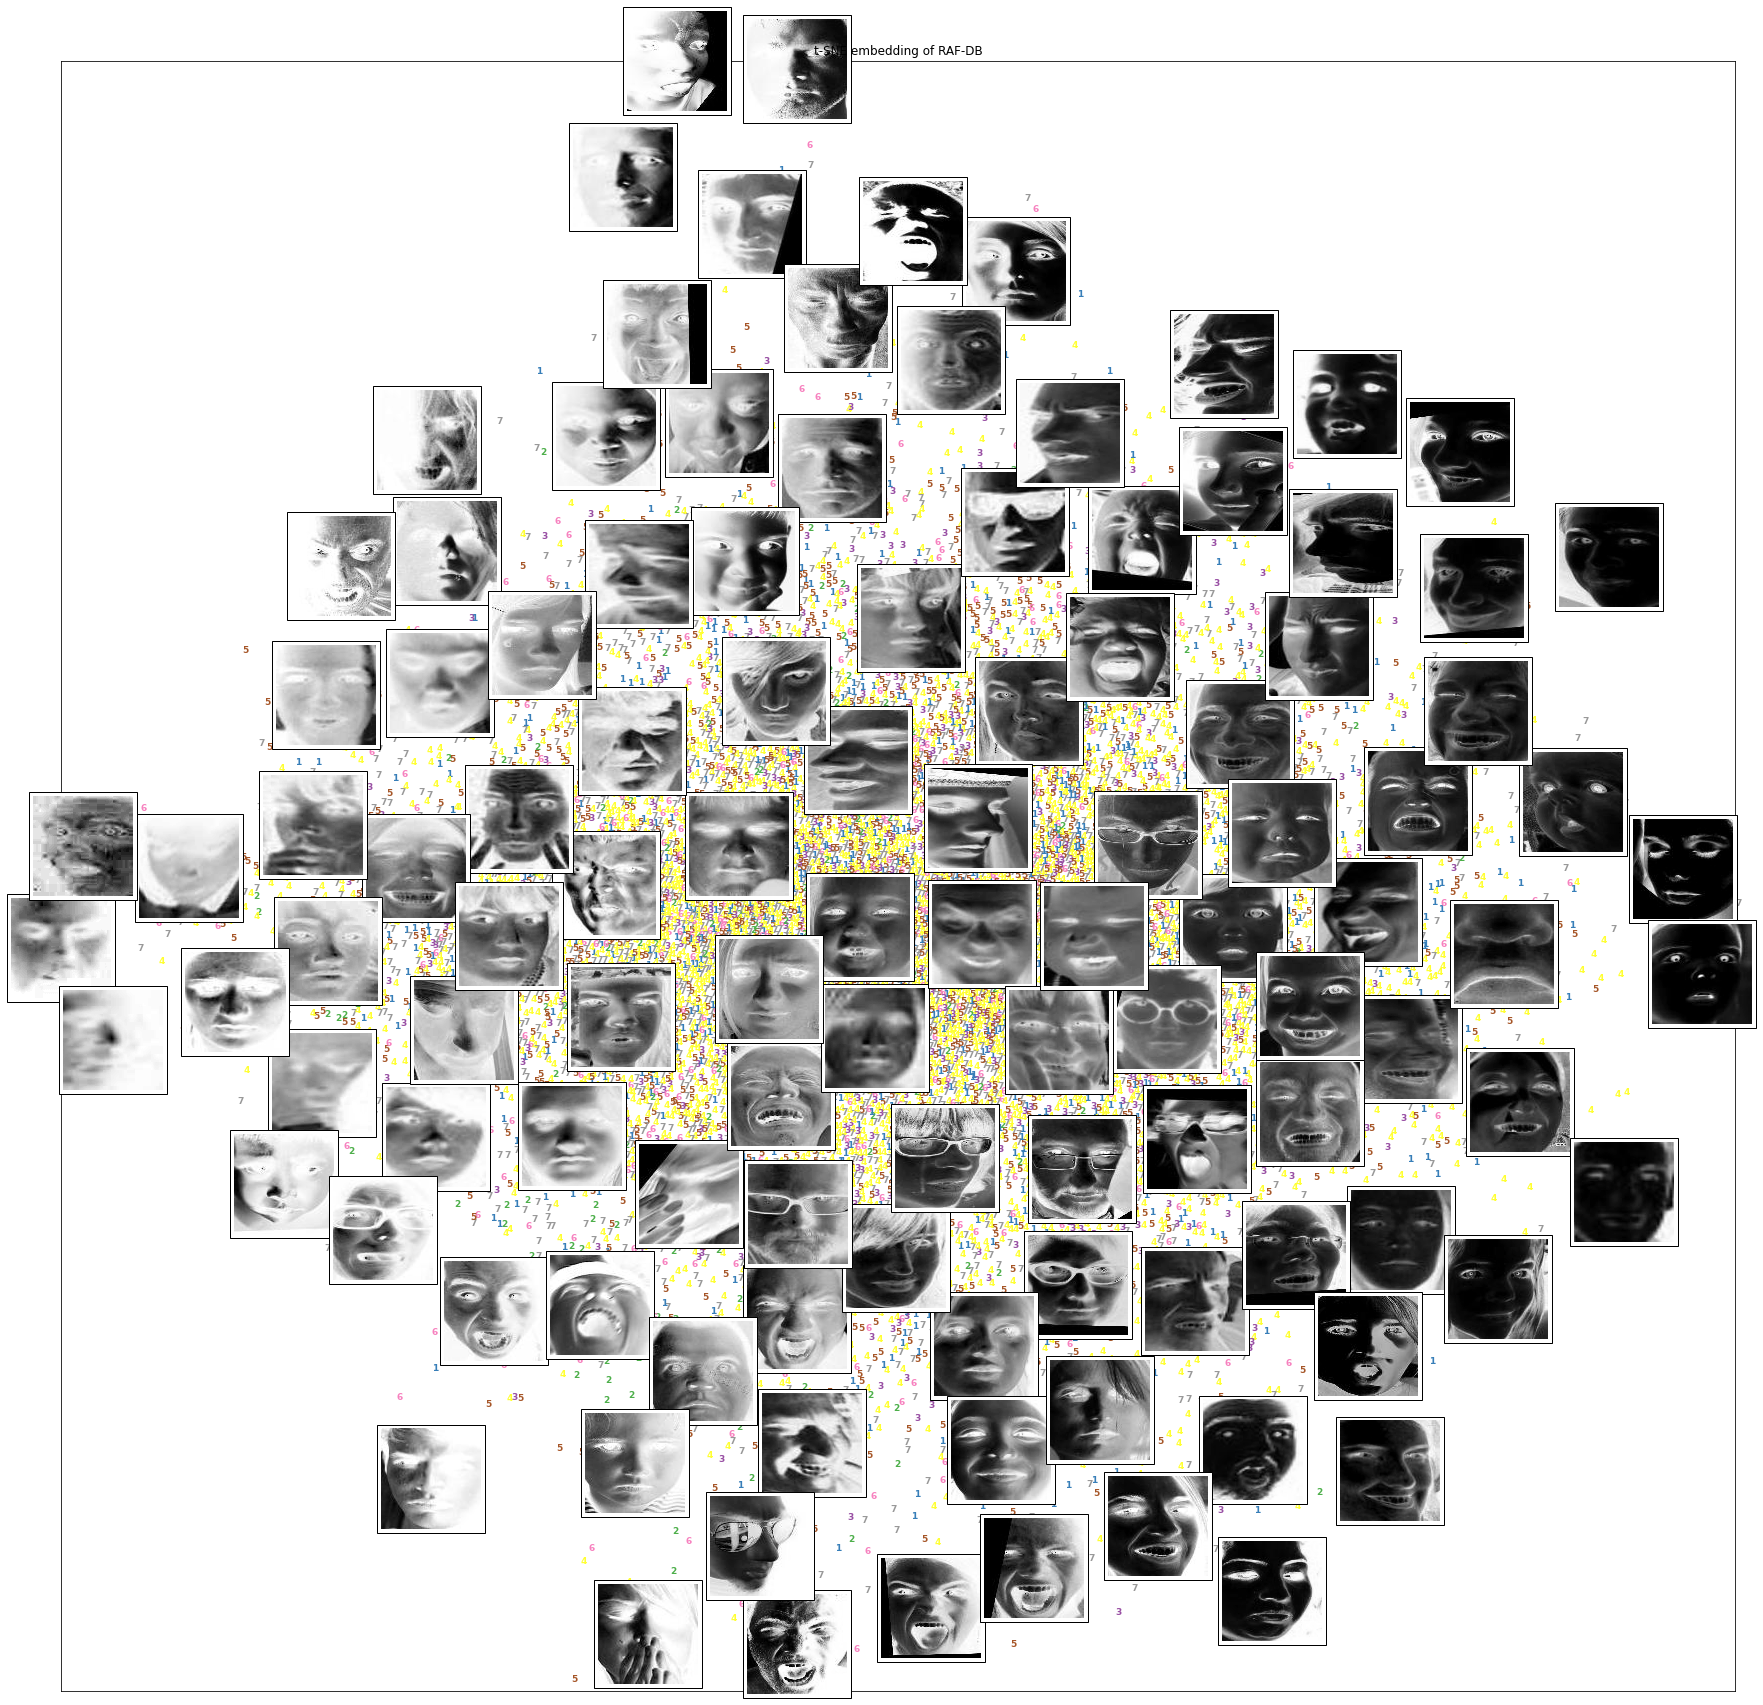

In [239]:
plot_embedding(X_tsne)

In [240]:
device = torch.device('cuda')

In [241]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [242]:
from torch.utils.data import Dataset
from torchvision import transforms
class RAFDBDataset(Dataset):
    """RAF-DB Dataset"""
    def __init__(self, file_path, img_path, split = 'train', transform=None):
        """
        Args:
            file_path (string): Path to the RAFDB txt file.
        """
        self.file_path = file_path
#         self.classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        self.labels = [t.rstrip().split() for t in open('list_patition_label.txt', 'r').readlines()]
        self.labels = np.array([[t[0][:-4]+"_aligned"+t[0][-4:], t[1]] for t in self.labels])
        
        index = np.random.permutation(len(self.labels))
        self.labels = self.labels[index]
        if split == 'train':
            self.labels = self.labels[:12000]
        elif split == 'valid':
            self.labels = self.labels[12000:]
        self.loader = pil_loader
        self.transform = transform
        self.img_path = img_path
        
    def __len__(self):  # dataset size
        return len(self.labels)
    
    def __getitem__(self, idx): # to return image and emotion when call `dataset[idx]`
        data = self.labels[idx]
        img = self.loader(self.img_path + data[0])
        label = int(data[1]) -1
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [243]:
validset = RAFDBDataset('list_patition_label.txt', 'rafdb/aligned/', split = 'valid', transform=transforms.ToTensor())
validloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False, num_workers=0)

In [244]:
net = torch.load('rafdb_resnet18.pth', map_location=device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [245]:
# put a model forward hook to collect the feature for each image

fc_collector = list()
def collect():
    def get_output(self, input, output):
        fc_collector.append(output.cpu())
    return get_output
net.avgpool.register_forward_hook(collect())

In [246]:
# test

pbar = tqdm(validloader, desc='Test')
y = list()
y_hat = list()
with torch.no_grad():
    for batch_idx, (image, label) in enumerate(pbar):
        image = image.to(device)
        y.append(label.item())
        output = net.forward(image)
        _, predicted = torch.max(output.data, 1)
        y_hat.append(predicted.item())       

Test: 100%|████████████████████████████████████████████████████████████████████████| 3339/3339 [03:00<00:00, 18.54it/s]


In [247]:
fc_collector = torch.cat(fc_collector)
fc_collector.shape

torch.Size([3339, 512, 1, 1])

In [248]:
fc_collector = fc_collector.view(fc_collector.shape[:2])
fc_collector.shape

torch.Size([3339, 512])

In [249]:
pca = PCA(n_components=2).fit_transform(fc_collector)

pca_1     pca_2  output
0     2.707000  0.958060       3
1    -3.984510  1.372556       6
2     6.787645  0.240482       3
3    -1.062837 -5.813278       4
4     6.347468 -0.955447       3
...        ...       ...     ...
3334  3.688044 -2.089484       3
3335  9.932569  0.477044       3
3336  0.539640 -2.870008       6
3337 -1.475068  5.829643       1
3338 -3.347263  6.553875       0

[3339 rows x 3 columns]

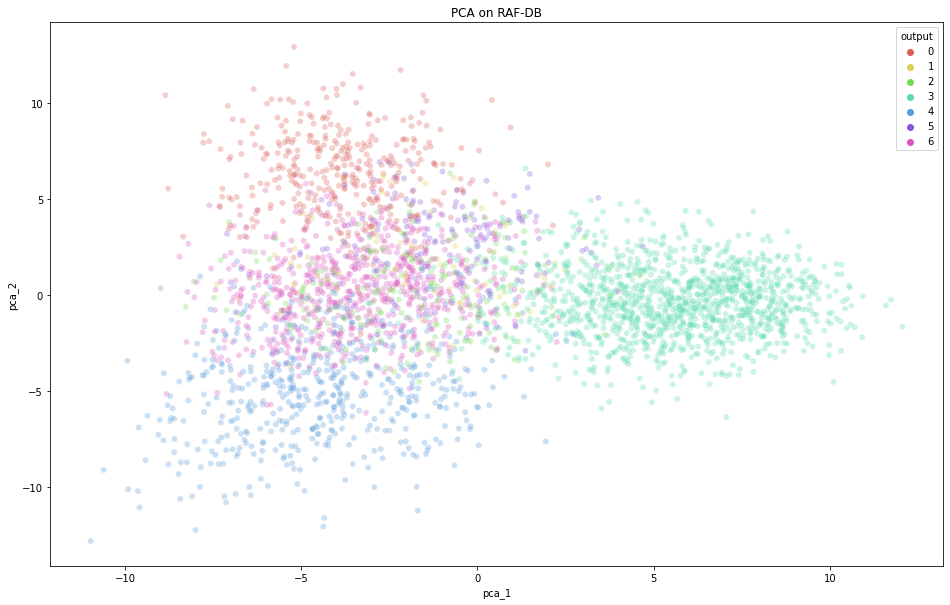

In [250]:
df = pd.DataFrame()
df['pca_1'] = pca[:, 0]
df['pca_2'] = pca[:, 1]
df['output'] = y
display(df)
plt.figure(figsize=(16,10))
plt.title(f'PCA on RAF-DB')
sns.scatterplot(
    x="pca_1", y="pca_2",
    hue="output",
    palette=sns.color_palette('hls', df['output'].nunique()),
    data=df.sample(frac=1),
    legend="full",
    alpha=0.3
)
plt.show()

In [251]:
tsne = TSNE(n_components=2).fit_transform(fc_collector)

tsne_1     tsne_2  output
0      2.264576  27.241554       3
1     -8.584389  -9.626774       6
2     28.185066  30.331314       3
3    -18.131151 -52.389709       4
4     37.922520  13.543142       3
...         ...        ...     ...
3334  24.889292  15.591122       3
3335  19.653229  44.827881       3
3336   7.111300 -23.796633       6
3337 -44.108387  -6.827641       1
3338 -40.922367 -12.542009       0

[3339 rows x 3 columns]

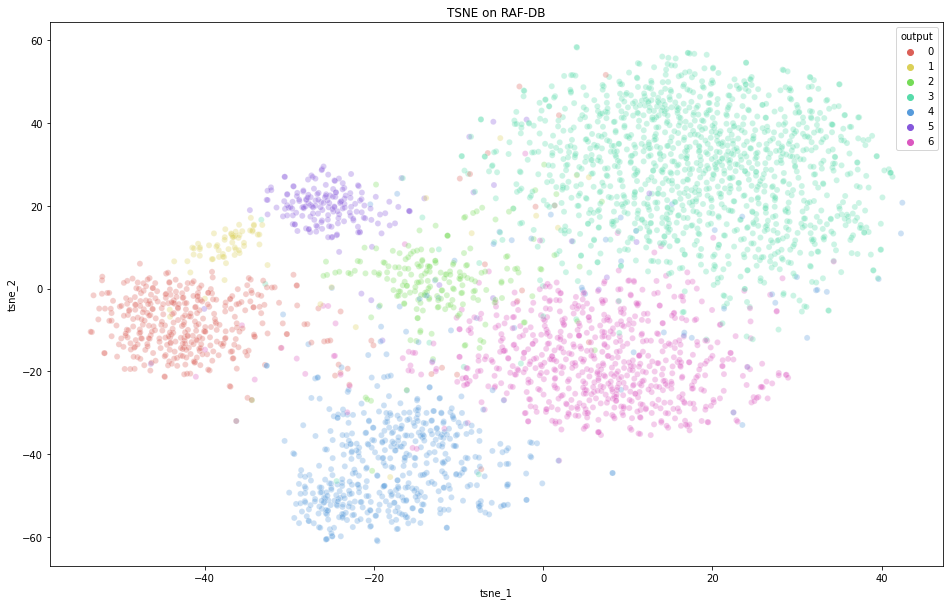

In [252]:
df = pd.DataFrame()
df['tsne_1'] = tsne[:, 0]
df['tsne_2'] = tsne[:, 1]
df['output'] = y
display(df)
plt.figure(figsize=(16,10))
plt.title(f'TSNE on RAF-DB')
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="output",
    palette=sns.color_palette('hls', df['output'].nunique()),
    data=df.sample(frac=1),
    legend="full",
    alpha=0.3
)
plt.show()